In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.train_bn import parameter_learning
from sklearn.model_selection import train_test_split
from gmr import GMM
from gmr.utils import check_random_state
from scipy import stats
from sklearn.datasets import make_spd_matrix, make_sparse_spd_matrix
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from bayesian.calculate_accuracy import calculate_acc, parall_accuracy
import cpuinfo
from scipy import integrate
import math
from scipy.linalg import sqrtm
from mpl_toolkits.mplot3d import Axes3D 
from bayesian.train_bn import structure_learning, parameter_learning, parameter_learning_mix, component, n_component
from preprocess.discretization import get_nodes_type, discretization, inverse_discretization, code_categories, get_nodes_sign
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from bayesian.calculate_accuracy import calculate_acc, LOO_validation, parall_accuracy
from joblib import Parallel, delayed
import cpuinfo
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.mixture import GaussianMixture
from operator import itemgetter 

## Генерация синтетических данных для проверки сетей со смесями

In [2]:
bn = dict()
bn['V'] = ['D1', 'D2', 'N1', 'N2', 'N3']
bn['E'] = [['D1', 'N1'],  ['D2', 'N1'], ['D2', 'N2'], ['N1', 'N3'], ['N1', 'N2']]

In [4]:
node_types = {'D1':'disc', 'D2': 'disc', 'N1': 'cont', 'N2': 'cont', 'N3': 'cont'}

In [5]:
n1 = 2
x1 = np.arange(n1)
p1 = tuple(np.random.dirichlet(np.ones(n1),size=1)[0])
custm1 = stats.rv_discrete(name='custm1', values=(x1, p1))

In [6]:
n2 = 4
x2 = np.arange(n2)
p2 = tuple(np.random.dirichlet(np.ones(n2),size=1)[0])
custm2 = stats.rv_discrete(name='custm2', values=(x2, p2))

In [7]:
mean = dict()
cov = dict()
for i in x1:
    for j in x2:
        n = random.randint(2,4)
        means = []
        covs = []
        for _ in range(n):
            means.append([random.randint(-1000, 1000), random.randint(-1000, 1000), random.randint(-1000, 1000)])
            covs.append(make_spd_matrix(3))
        mean[str(i)+str(j)] = means
        cov[str(i)+str(j)] = covs


In [8]:
df = pd.DataFrame(columns=['D1', 'D2', 'N1', 'N2', 'N3'])
df['D1'] = custm1.rvs(size=5000)
df['D2'] = custm2.rvs(size=5000)

In [9]:
df_new = pd.DataFrame()
for i in x1:
    for j in x2:
        sample = df.loc[(df['D1'] == i) & (df['D2'] == j)]
        size = sample.shape[0]
        means = mean[str(i)+str(j)]
        covs = cov[str(i)+str(j)]
        n = len(means)
        model = GMM(n_components=n, priors=[1/n for _ in range(n)], means=means, covariances=covs)
        cont_data = model.sample(size)
        sample[['N1', 'N2', 'N3']] = cont_data
        df_new = pd.concat([df_new, sample])
df_new.reset_index(inplace=True, drop=True)

<ipython-input-9-27497bb46744>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample[['N1', 'N2', 'N3']] = cont_data
<ipython-input-9-27497bb46744>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample[['N1', 'N2', 'N3']] = cont_data
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [10]:
df_new

,D1,D2,N1,N2,N3
0,0,1,14.359222,557.038768,-80.759316
1,0,1,15.488483,555.984642,-81.432751
2,0,1,14.986376,558.050609,-79.686448
3,0,1,13.818422,557.289212,-79.655574
4,0,1,13.585891,559.245474,-77.995491
...,...,...,...,...,...
4995,1,3,386.671713,-552.331815,558.468266
4996,1,3,385.669878,-552.599284,557.940901
4997,1,3,386.221799,-554.534935,558.334295
4998,1,3,385.556715,-551.196778,557.258663


C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='N1', ylabel='Density'>

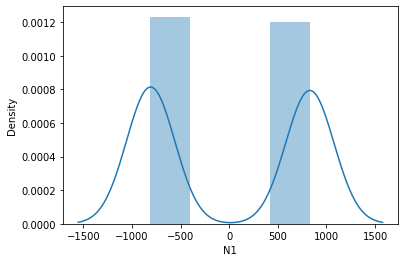

In [11]:
sample = df_new.loc[(df_new['D1'] == 0) & (df_new['D2'] == 2)]
#sns.kdeplot(df_new['N1'], df_new['N3'])
sns.distplot(sample['N1'])

In [12]:
df_new['D1'] = df_new['D1'].apply(lambda x: str(x))
df_new['D2'] = df_new['D2'].apply(lambda x: str(x))
train, test = train_test_split(df_new, test_size=0.1)
train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

In [13]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [6]:
train['D1'] = train['D1'].apply(lambda x: str(x))
train['D2'] = train['D2'].apply(lambda x: str(x))
test['D1'] = test['D1'].apply(lambda x: str(x))
test['D2'] = test['D2'].apply(lambda x: str(x))

In [7]:
params = parameter_learning(train, node_types, bn, 'mix')
save_structure(bn, 'synth_net')
skel = read_structure('synth_net')
save_params(params, 'synth_net_param')
params = read_params('synth_net_param')
all_bn = HyBayesianNetwork(skel, params)

In [8]:
cpu_count = max(cpuinfo.get_cpu_info()['count']-1, 1)
acc, rmse, real, pred, indexes = parall_accuracy(all_bn, test, bn['V'], 'mix', cpu_count)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='N1', ylabel='N3'>

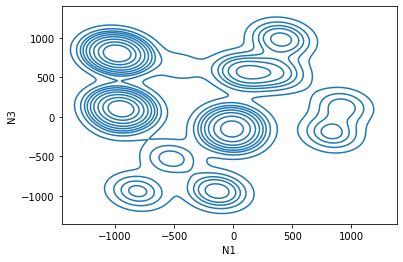

In [15]:
# sample = train.loc[(train['D1'] == '0') & (train['D2'] == '1')]
# sns.distplot(sample['N1'])
sns.kdeplot(train['N1'], train['N3'])

In [13]:
#simple
rmse

{'N1': 276.22, 'N2': 311.148, 'N3': 488.471}

In [9]:
#mix_lrts
rmse

{'N1': 274.024, 'N2': 49.506, 'N3': 381.38}

In [19]:
#mix_aic_bic
rmse

{'N1': 274.276, 'N2': 49.506, 'N3': 217.64}

In [9]:
#mix_quantile
rmse

{'N1': 275.98, 'N2': 7.852, 'N3': 189.863}

## Вычисление расстояния Махолонобиса и model-weighted distance

In [62]:
means = []
covs = []
for _ in range(2):
    means.append([random.randint(-100, -10), random.randint(10, 55)])
    covs.append(make_spd_matrix(2))
 

In [63]:
means

[[-43, 27], [-71, 47]]

In [64]:
covs

[array([[2.05072762, 0.2984639 ],
        [0.2984639 , 0.14172644]]),
 array([[ 2.16912756, -0.38252243],
        [-0.38252243,  0.2832131 ]])]

In [65]:
model = GMM(n_components=2, priors=[1/2 for _ in range(2)], means=means, covariances=covs)
sample = model.sample(100)

In [66]:
sample = pd.DataFrame(data = sample, columns=['C1', 'C2'])
sample

,C1,C2
0,-43.602316,27.068765
1,-44.643817,27.018894
2,-43.661124,26.659291
3,-43.383707,26.766429
4,-40.924506,27.303949
...,...,...
95,-69.878587,46.220091
96,-70.998668,47.052025
97,-71.447884,47.659865
98,-67.782671,46.418734


C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='C1', ylabel='C2'>

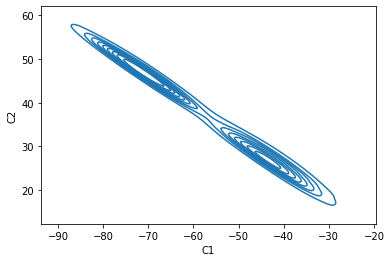

In [67]:
sns.kdeplot(sample['C1'], sample['C2'])

In [68]:
c = []
for i in model.to_responsibilities(sample):
    if i[0] == 1:
        c.append(0)
    else:
        c.append(1)


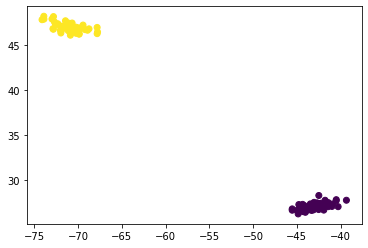

In [69]:
plt.scatter(sample['C1'], sample['C2'], c=c)

In [70]:
sample['component'] = c
sample

,C1,C2,component
0,-43.602316,27.068765,0
1,-44.643817,27.018894,0
2,-43.661124,26.659291,0
3,-43.383707,26.766429,0
4,-40.924506,27.303949,0
...,...,...,...
95,-69.878587,46.220091,1
96,-70.998668,47.052025,1
97,-71.447884,47.659865,1
98,-67.782671,46.418734,1


In [3]:
def erf(b):
    func = lambda x: np.exp(-x**2)
    return integrate.quad(func, 0, b)[0]


In [4]:
def weighted_distance(x1, x2, means, cov, w):
    v = x1 - x2
    G_nominator = 0
    G_denominator = 0
    for k in range(len(w)):
        cov_inv = np.linalg.inv(cov[k])
        pi_k = w[k]
        u = np.transpose(means[k] - np.transpose(x2))
        v_t = np.transpose(v)
        u_t = np.transpose(u)
        b2 = np.linalg.inv(np.dot(np.dot(v_t, cov_inv),v))[0][0]
        a = np.dot(np.dot(b2*v_t,cov_inv), u)[0][0]
        m = np.dot(np.dot(v_t, cov_inv), u)
        m2 = np.dot(m,m)
        Z = np.dot(np.dot(u_t,cov_inv), u) - b2*m2
        Z = Z[0][0]
        bound1 = (1 - a) / math.sqrt(2*b2)
        bound2 = -a / math.sqrt(2*b2)
        erf1 = erf(bound1)
        erf2 = erf(bound2)
        diff_erf = erf1 - erf2
        exp_power = np.exp((-1*Z)/2)
        sqrt_b2 = math.sqrt((math.pi*b2)/2)
        integral = sqrt_b2*exp_power*diff_erf
        G_nominator += np.dot(pi_k*cov_inv, integral)
        G_denominator += pi_k*integral
    G = G_nominator/G_denominator
    d = np.dot(np.dot(np.transpose(v), G),v)
    return d[0][0]
        
    

In [5]:
def mah_distance(x1, x2, cov):
    v = x1 - x2
    v_t = np.transpose(v)
    cov_inv = np.linalg.inv(cov)
    d = np.dot(np.dot(v_t, cov_inv), v)
    return d[0][0]



In [74]:
x1 = np.transpose(sample.loc[sample['component'] == 0][['C1', 'C2']].values)
x2 = np.transpose(sample.loc[sample['component'] == 1][['C1', 'C2']].values[0:42])


In [78]:
dist_matrix11 = np.empty([42, 42])
for i in range(42):
    for j in range(42):
        X1 = np.array([[x1[0][i]], [x1[1][i]]])
        X2 = np.array([[x1[0][j]], [x1[1][j]]])
        d = mah_distance(X1, X2, covs[0])
        dist_matrix11[i][j] = d

In [79]:
dist_matrix22 = np.empty([42, 42])
for i in range(42):
    for j in range(42):
        X1 = np.array([[x2[0][i]], [x2[1][i]]])
        X2 = np.array([[x2[0][j]], [x2[1][j]]])
        d = mah_distance(X1, X2, covs[1])
        dist_matrix22[i][j] = d

In [80]:
с2_mean = np.median(dist_matrix22)
с1_mean = np.median(dist_matrix11)

In [81]:
dist_matrix21 = np.empty([42, 42])
for i in range(42):
    for j in range(42):
        X1 = np.array([[x1[0][i]], [x1[1][i]]])
        X2 = np.array([[x2[0][j]], [x2[1][j]]])
        d = weighted_distance(X2, X1, means, covs, [1/2, 1/2])
        dist_matrix21[j][i] = d

In [82]:
c21_mean = np.median(dist_matrix21)

In [83]:
dist_matrix12 = np.empty([42, 42])
for i in range(42):
    for j in range(42):
        X1 = np.array([[x1[0][i]], [x1[1][i]]])
        X2 = np.array([[x2[0][j]], [x2[1][j]]])
        d = weighted_distance(X1, X2, means, covs, [1/2, 1/2])
        dist_matrix12[i][j] = d

In [84]:
c12_mean = np.median(dist_matrix12)

<AxesSubplot:>

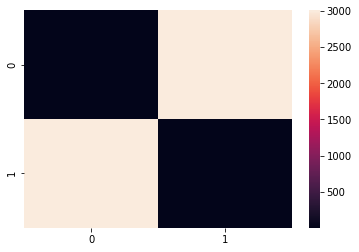

In [85]:
dists = [[с1_mean, c12_mean], [c21_mean, с2_mean]]
sns.heatmap(dists)

<AxesSubplot:>

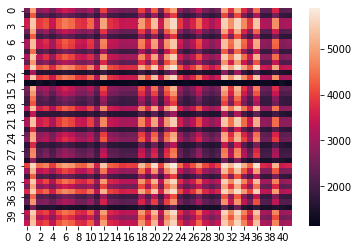

In [77]:
sns.heatmap(dist_matrix12)

In [2]:
random_state = check_random_state(0)

In [87]:
mean = []
cov = []
for k in range(3):
    mean.append([random.randint(0, 10), random.randint(0, 10), random.randint(0, 10)])
    cov.append(make_spd_matrix(3))
model = GMM(n_components=3, priors=w, means=mean, covariances=cov)
sample = model.sample(1000)
sample = pd.DataFrame(data = sample, columns=['C1', 'C2', 'C3'])
range_c1 = sample['C1'].max() - sample['C1'].min()
range_c2 = sample['C2'].max() - sample['C2'].min()
range_c3 = sample['C3'].max() - sample['C3'].min()
sample['C1'] = sample['C1'].apply(lambda x: x / range_c1)
sample['C2'] = sample['C2'].apply(lambda x: x / range_c2)
sample['C3'] = sample['C3'].apply(lambda x: x / range_c3)

In [89]:
model_new = GMM(n_components=3).from_samples(sample[['C1', 'C2', 'C3']].values)

In [90]:
model_new.means

array([[0.3797972 , 0.56099053, 0.715009  ],
       [0.09431778, 0.00672557, 0.36904361],
       [0.1022874 , 0.44196952, 0.36004776]])

## Генерация трёхмерной смеси с тремя компонентами и расчёт расстояний

In [78]:
dist_matrix = []
means = []
covs = []
w = [1/3, 1/3, 1/3]
for _ in range(1):
    print(_)
    mean = []
    cov = []
    for k in range(3):
        if k == 0:
            mean.append([random.randint(0, 50), random.randint(0, 50), random.randint(0, 50)])
        if k == 1:
            mean.append([random.randint(25, 75), random.randint(25, 75), random.randint(25, 75)])
        if k == 2:
            mean.append([random.randint(50, 100), random.randint(50, 100), random.randint(50, 100)])
        cov.append(np.array([[ 1, 0, 0],
       [0,  1,  0],
       [0,  0,  1]]))
        
    model = GMM(n_components=3, priors=w, means=mean, covariances=cov)
    sample = model.sample(500)
    sample = pd.DataFrame(data = sample, columns=['C1', 'C2', 'C3'])
    
    means.append(mean)
    covs.append(cov)
    
    c = []
    for i in model.to_responsibilities(sample):
        c.append(i.argmax())
    sample['comp'] = c
    x1 = sample.loc[sample['comp'] == 0][['C1', 'C2', 'C3']].values
    x2 = sample.loc[sample['comp'] == 1][['C1', 'C2', 'C3']].values
    x3 = sample.loc[sample['comp'] == 2][['C1', 'C2', 'C3']].values
    length = []
    length.append(len(x1))
    length.append(len(x2))
    length.append(len(x3))
    min_len = np.min(length)
    x1 = np.transpose(x1[0:min_len])
    x2 = np.transpose(x2[0:min_len])
    x3 = np.transpose(x3[0:min_len])
    dist_matrix11 = np.empty([min_len, min_len])
    dist_matrix22 = np.empty([min_len, min_len])
    dist_matrix33 = np.empty([min_len, min_len])
    dist_matrix12 = np.empty([min_len, min_len])
    dist_matrix13 = np.empty([min_len, min_len])
    dist_matrix23 = np.empty([min_len, min_len])
    for i in range(min_len):
        for j in range(min_len):
            X1 = np.array([[x1[0][i]], [x1[1][i]], [x1[2][i]]])
            Y1 = np.array([[x1[0][j]], [x1[1][j]],  [x1[2][j]]])
            d = mah_distance(X1, Y1, cov[0])
            dist_matrix11[i][j] = d
            X2 = np.array([[x2[0][i]], [x2[1][i]],  [x2[2][i]]])
            Y2 = np.array([[x2[0][j]], [x2[1][j]], [x2[2][j]]])
            d = mah_distance(X2, Y2, cov[1])
            dist_matrix22[i][j] = d
            X3 = np.array([[x3[0][i]], [x3[1][i]], [x3[2][i]]])
            Y3 = np.array([[x3[0][j]], [x3[1][j]], [x3[2][j]]])
            d = mah_distance(X3, Y3, cov[2])
            dist_matrix33[i][j] = d
            dist_matrix12[i][j] = weighted_distance(X1,Y2,mean, cov, w)
            dist_matrix13[i][j] = weighted_distance(X1, Y3, mean, cov, w)
            dist_matrix23[i][j] = weighted_distance(X2, Y3, mean, cov, w)
    final_dist = [[np.mean(dist_matrix11), np.mean(dist_matrix12), np.mean(dist_matrix13)], [np.mean(dist_matrix12), np.mean(dist_matrix22), np.mean(dist_matrix23)], [np.mean(dist_matrix13), np.mean(dist_matrix23), np.mean(dist_matrix33)]]
    dist_matrix.append(final_dist)

    
    
    
    



0
[[-8.16213935e-01  2.05125872e+01  4.99497051e+01]
 [ 1.16612625e+00  2.22708804e+01  5.03941578e+01]
 [ 4.94293016e-01  2.05275025e+01  5.07522818e+01]
 [ 1.57158926e+00  2.09105786e+01  5.06529472e+01]
 [ 5.66122018e-01  2.30179752e+01  5.12081871e+01]
 [ 3.48352148e+00  2.12282939e+01  4.81552477e+01]
 [ 2.20905096e+00  2.20793158e+01  5.00859200e+01]
 [-1.39872243e+00  2.13238570e+01  4.82441466e+01]
 [ 1.33465960e+00  2.30885438e+01  4.98747131e+01]
 [-8.20626381e-01  2.13366449e+01  4.85680159e+01]
 [ 1.18708736e+00  2.03562589e+01  4.98777517e+01]
 [ 1.54555120e+00  2.17914762e+01  4.74037327e+01]
 [ 1.35530241e+00  2.35256172e+01  4.94260382e+01]
 [ 1.87354063e+00  2.22228048e+01  4.97412084e+01]
 [ 4.21244679e-01  2.26300703e+01  4.86799023e+01]
 [ 2.54299306e+00  2.27026215e+01  4.93962980e+01]
 [ 1.99027090e+00  2.24602798e+01  4.90300911e+01]
 [ 1.53037845e+00  2.24760091e+01  4.81592878e+01]
 [ 2.72424281e+00  2.33940176e+01  4.78847364e+01]
 [-7.34947679e-01  2.25489197

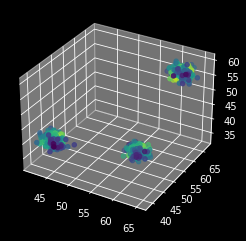

In [127]:
mean = means[168]
cov = covs[168]
model = GMM(n_components=3, priors=w, means=mean, covariances=cov)
sample = model.sample(1000)
x = sample[:,0]
y = sample[:,1]
z = sample[:,2]
xyz = np.vstack([x,y,z])
density = stats.gaussian_kde(xyz)(xyz) 

idx = density.argsort()
x, y, z, density = x[idx], y[idx], z[idx], density[idx]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=density)
plt.show()

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

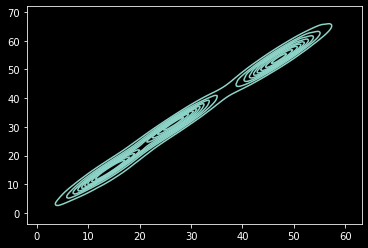

In [22]:
sns.kdeplot(x,y)

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

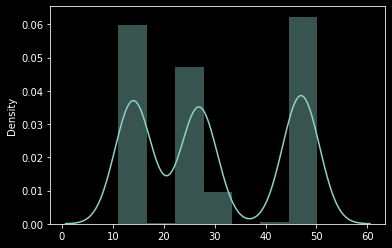

In [23]:
sns.distplot(x)

<AxesSubplot:>

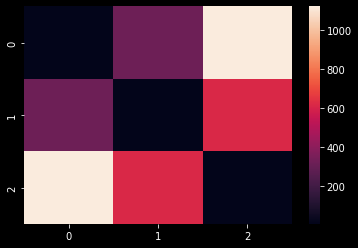

In [64]:
sns.heatmap(dist_matrix[168])

In [25]:
mean_components_dist = []
for i in range(300):
    matrix = dist_matrix[i]
    mean_components_dist.append((matrix[0][1] + matrix[0][2] + matrix[1][2]) / 3)

In [62]:
for i in range(300):
    if mean_components_dist[i] < 1000:
        print(i)

168


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

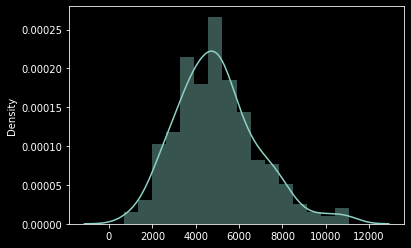

In [61]:
sns.distplot(mean_components_dist)

## Расчёт RMSE на сети для всех сгенерированных распределений

In [3]:
cpu_count = max(cpuinfo.get_cpu_info()['count']-1, 1)
cpu_count

11

In [27]:
node_types = {'C1':'cont', 'C2':'cont', 'C3':'cont'}
columns_for_disc = ['C1', 'C2', 'C3']
rmse_all_column = []
structures = []
samples_train = []
samples_test = []
real_iter = []
pred_iter = []
for i in range(300):
    print(i)
    mean = means[i]
    cov = covs[i]
    model = GMM(n_components=3, priors=w, means=mean, covariances=cov)
    sample = model.sample(5000)
    sample = pd.DataFrame(data = sample, columns=['C1', 'C2', 'C3'])
    train, test = train_test_split(sample, test_size=0.02)
    train.reset_index(inplace=True, drop=True)
    test.reset_index(inplace=True, drop=True)
    samples_train.append(train)
    samples_test.append(test)
    discrete_data, coder = discretization(train, 'equal_frequency', columns_for_disc)
    bn_full = structure_learning(discrete_data, 'HC', node_types, 'K2')
    structures.append(bn_full['E'])
    params = parameter_learning(train, node_types, bn_full, 'mix')
    save_structure(bn_full, 'all_net')
    skel = read_structure('all_net')
    save_params(params, 'all_net_param')
    params = read_params('all_net_param')
    all_bn = HyBayesianNetwork(skel, params)
    acc, rmse, real, pred, index = parall_accuracy(all_bn, test, columns_for_disc, 'mix', cpu_count)
    real_iter.append(real)
    pred_iter.append(pred)
    rmse_all_column.append(rmse)


    


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [65]:
node_types = {'C1':'cont', 'C2':'cont', 'C3':'cont'}
columns_for_disc = ['C1', 'C2', 'C3']
rmse_simple = []
real_simple = []
pred_simple = []
for i in range(300):
    print(i)
    train = samples_train[i]
    test = samples_test[i]
    discrete_data, coder = discretization(train, 'equal_frequency', columns_for_disc)
    bn_full = structure_learning(discrete_data, 'HC', node_types, 'K2')
    params = parameter_learning(train, node_types, bn_full, 'simple')
    save_structure(bn_full, 'all_net')
    skel = read_structure('all_net')
    save_params(params, 'all_net_param')
    params = read_params('all_net_param')
    all_bn = HyBayesianNetwork(skel, params)
    acc, rmse, real, pred, index = parall_accuracy(all_bn, test, columns_for_disc, 'simple', cpu_count)
    real_simple.append(real)
    pred_simple.append(pred)
    rmse_simple.append(rmse)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [203]:
mean_rmse = []
for i in range(300):
    r1 = rmse_all_column[i]['C1'] / np.std(real_iter[i][0])
    r2 = rmse_all_column[i]['C2'] / np.std(real_iter[i][1])
    r3 = rmse_all_column[i]['C3'] / np.std(real_iter[i][2])
    mean_rmse.append((r1 + r2 + r3) / 3)

In [97]:
mean_rmse_simple = []
for i in range(300):
    r1 = rmse_simple[i]['C1'] /  np.std(real_simple[i][0])
    r2 = rmse_simple[i]['C2'] / np.std(real_simple[i][1])
    r3 = rmse_simple[i]['C3'] / np.std(real_simple[i][2])
    mean_rmse_simple.append((r1 + r2 + r3) / 3)

In [191]:
rmse_decrease = []
for i in range(300):
    r1 = rmse_all_column[i]['C1'] / np.std(real_iter[i][0])
    r2 = rmse_all_column[i]['C2'] / np.std(real_iter[i][1])
    r3 = rmse_all_column[i]['C3'] / np.std(real_iter[i][2])

    r1s = rmse_simple[i]['C1'] /  np.std(real_simple[i][0])
    r2s = rmse_simple[i]['C2'] / np.std(real_simple[i][1])
    r3s = rmse_simple[i]['C3'] / np.std(real_simple[i][2])



    decrease1 = 100 - ((r1 * 100) / r1s)
    decrease2 = 100 - ((r2 * 100) / r2s)
    decrease3 = 100 - ((r3 * 100) / r3s)
    rmse_decrease.append(decrease3)

Text(0, 0.5, 'Mean NRMSE')

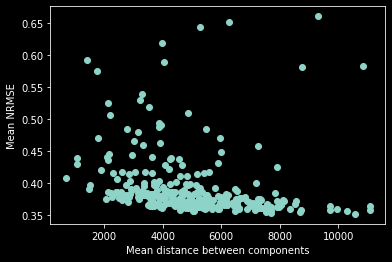

In [96]:
plt.scatter(mean_components_dist, mean_rmse)
plt.xlabel('Mean distance between components')
plt.ylabel('Mean NRMSE')

Text(0, 0.5, 'Mean RMSE simple')

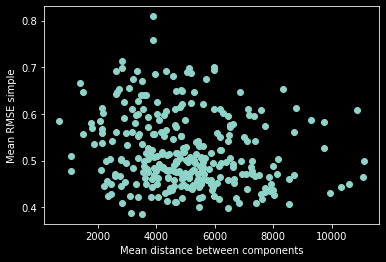

In [98]:
plt.scatter(mean_components_dist, mean_rmse_simple)
plt.xlabel('Mean distance between components')
plt.ylabel('Mean RMSE simple')

Text(0, 0.5, 'Mean % NRMSE decrease C3')

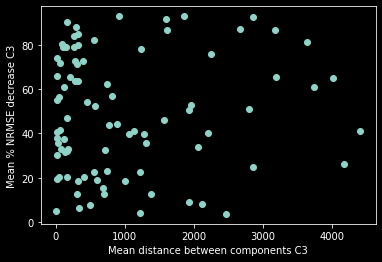

In [193]:
plt.scatter(itemgetter(*index)(c3_dist), itemgetter(*index)(rmse_decrease))
plt.xlabel('Mean distance between components C3')
plt.ylabel('Mean % NRMSE decrease C3')

In [99]:
uniq_structures = []
for s in structures:
    if s not in uniq_structures:
        uniq_structures.append(s)

In [100]:
uniq_structures

[[['C2', 'C3'], ['C2', 'C1'], ['C3', 'C1']],
 [['C1', 'C2'], ['C1', 'C3'], ['C2', 'C3']],
 [['C1', 'C3'], ['C1', 'C2'], ['C3', 'C2']],
 [['C2', 'C1'], ['C3', 'C2'], ['C3', 'C1']],
 [['C2', 'C1'], ['C2', 'C3'], ['C3', 'C1']],
 [['C1', 'C2'], ['C3', 'C1'], ['C3', 'C2']],
 [['C1', 'C2'], ['C1', 'C3'], ['C3', 'C2']],
 [['C1', 'C3'], ['C2', 'C1'], ['C2', 'C3']],
 [['C1', 'C3'], ['C1', 'C2'], ['C2', 'C3']],
 [['C2', 'C1'], ['C3', 'C1'], ['C3', 'C2']],
 [['C1', 'C2'], ['C3', 'C2'], ['C3', 'C1']],
 [['C1', 'C3'], ['C2', 'C1']],
 [['C2', 'C1'], ['C3', 'C2']],
 [['C1', 'C3'], ['C2', 'C3'], ['C2', 'C1']],
 [['C1', 'C3'], ['C1', 'C2']],
 [['C1', 'C2'], ['C3', 'C1']]]

## Вычисление расстояний по узлам

In [109]:
c1_dist = []
c2_dist = []
c3_dist = []
for i in range(300):
    print(i)
    mean = means[i]
    cov = covs[i]
    model = GMM(n_components=3, priors=w, means=mean, covariances = cov)
    sample = model.sample(500)
    sample = pd.DataFrame(data=sample, columns=['C1', 'C2', 'C3'])
    X = sample[['C1']].values
    Y = sample[['C2']].values
    Z = sample[['C3']].values
    model1 = GMM(n_components=3).from_samples(X)
    model2 = GMM(n_components=3).from_samples(Y)
    model3 = GMM(n_components=3).from_samples(Z)
    mean1 = model1.means
    cov1 = model1.covariances
    prior1 = model1.priors
    mean2 = model2.means
    cov2 = model2.covariances
    prior2 = model2.priors
    mean3 = model3.means
    cov3 = model3.covariances
    prior3 = model3.priors

    sample1 = model1.sample(300)
    sample1 = pd.DataFrame(data=sample1, columns=['C1'])
    sample2 = model2.sample(300)
    sample2 = pd.DataFrame(data=sample2, columns=['C2'])
    sample3 = model3.sample(300)
    sample3 = pd.DataFrame(data=sample3, columns=['C3'])

    c1 = []
    c2 = []
    c3 = []
    for i1, i2, i3 in zip(model1.to_responsibilities(sample1.values), model2.to_responsibilities(sample2.values), model3.to_responsibilities(sample3.values)):
        c1.append(i1.argmax())
        c2.append(i2.argmax())
        c3.append(i3.argmax())
    sample1['comp'] = c1
    sample2['comp'] = c2
    sample3['comp'] = c3
    x11 = sample1.loc[sample1['comp'] == 0]['C1'].values
    x21 = sample1.loc[sample1['comp'] == 1]['C1'].values
    x31 = sample1.loc[sample1['comp'] == 2]['C1'].values
    length1 = []
    length1.append(len(x11))
    length1.append(len(x21))
    length1.append(len(x31))
    min_len1 = np.min(length1)
    x11 = np.transpose(x11[0:min_len1])
    x21 = np.transpose(x21[0:min_len1])
    x31 = np.transpose(x31[0:min_len1])
    dist_matrix121 = np.empty([min_len1, min_len1])
    dist_matrix131 = np.empty([min_len1, min_len1])
    dist_matrix231 = np.empty([min_len1, min_len1])

    x12 = sample2.loc[sample2['comp'] == 0]['C2'].values
    x22 = sample2.loc[sample2['comp'] == 1]['C2'].values
    x32 = sample2.loc[sample2['comp'] == 2]['C2'].values
    length2 = []
    length2.append(len(x12))
    length2.append(len(x22))
    length2.append(len(x32))
    min_len2 = np.min(length2)
    x12 = np.transpose(x12[0:min_len2])
    x22 = np.transpose(x22[0:min_len2])
    x32 = np.transpose(x32[0:min_len2])
    dist_matrix122 = np.empty([min_len2, min_len2])
    dist_matrix132 = np.empty([min_len2, min_len2])
    dist_matrix232 = np.empty([min_len2, min_len2])


    x13 = sample3.loc[sample3['comp'] == 0]['C3'].values
    x23 = sample3.loc[sample3['comp'] == 1]['C3'].values
    x33 = sample3.loc[sample3['comp'] == 2]['C3'].values
    length3 = []
    length3.append(len(x13))
    length3.append(len(x23))
    length3.append(len(x33))
    min_len3 = np.min(length3)
    x13 = np.transpose(x13[0:min_len3])
    x23 = np.transpose(x23[0:min_len3])
    x33 = np.transpose(x33[0:min_len3])
    dist_matrix123 = np.empty([min_len3, min_len3])
    dist_matrix133 = np.empty([min_len3, min_len3])
    dist_matrix233 = np.empty([min_len3, min_len3])


    for i in range(min_len1):
        for j in range(min_len1):
            X1 = np.array([[x11[i]]])
            X2 = np.array([[x21[i]]])
            X3 = np.array([[x31[i]]])
            dist_matrix121[i][j] = weighted_distance(X1,X2,mean1, cov1, prior1)
            dist_matrix131[i][j] = weighted_distance(X1, X3, mean1, cov1, prior1)
            dist_matrix231[i][j] = weighted_distance(X2, X3, mean1, cov1, prior1)
    c1_dist.append((np.mean(dist_matrix121) + np.mean(dist_matrix131) + np.mean(dist_matrix231)) / 3)


    for i in range(min_len2):
        for j in range(min_len2):
            X1 = np.array([[x12[i]]])
            X2 = np.array([[x22[i]]])
            X3 = np.array([[x32[i]]])
            dist_matrix122[i][j] = weighted_distance(X1,X2,mean2, cov2, prior2)
            dist_matrix132[i][j] = weighted_distance(X1, X3, mean2, cov2, prior2)
            dist_matrix232[i][j] = weighted_distance(X2, X3, mean2, cov2, prior2)
    c2_dist.append((np.mean(dist_matrix122) + np.mean(dist_matrix132) + np.mean(dist_matrix232)) / 3)


    for i in range(min_len3):
        for j in range(min_len3):
            X1 = np.array([[x13[i]]])
            X2 = np.array([[x23[i]]])
            X3 = np.array([[x33[i]]])
            dist_matrix123[i][j] = weighted_distance(X1,X2,mean3, cov3, prior3)
            dist_matrix133[i][j] = weighted_distance(X1, X3, mean3, cov3, prior3)
            dist_matrix233[i][j] = weighted_distance(X2, X3, mean3, cov3, prior3)
    c3_dist.append((np.mean(dist_matrix123) + np.mean(dist_matrix133) + np.mean(dist_matrix233)) / 3)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
2

In [110]:
mean_rmse_c1 = []
for i in range(300):
    r1 = rmse_all_column[i]['C1'] / np.std(real_iter[i][0])
    mean_rmse_c1.append(r1)

In [156]:
mean_rmse_c2 = []
for i in range(300):
    r1 = rmse_all_column[i]['C2'] / np.std(real_iter[i][1])
    mean_rmse_c2.append(r1)

In [165]:
mean_rmse_c3 = []
for i in range(300):
    r1 = rmse_all_column[i]['C3'] / np.std(real_iter[i][2])
    mean_rmse_c3.append(r1)

In [182]:
parents_c1 = []
index = []
for i in range(300):
    n = 0
    struct = structures[i]
    for pair in struct:
        if ('C1' in pair) & (pair[1] == 'C1'):
            n += 1
    if n == 2:
        index.append(i)
    parents_c1.append(n)

In [189]:
parents_c2 = []
index = []
for i in range(300):
    n = 0
    struct = structures[i]
    for pair in struct:
        if ('C2' in pair) & (pair[1] == 'C2'):
            n += 1
    if n == 2:
        index.append(i)
    parents_c2.append(n)

In [192]:
parents_c3 = []
index = []
for i in range(300):
    n = 0
    struct = structures[i]
    for pair in struct:
        if ('C3' in pair) & (pair[1] == 'C3'):
            n += 1
    if n == 2:
        index.append(i)
    parents_c3.append(n)

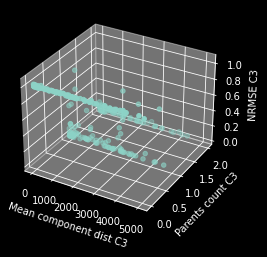

In [167]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = c3_dist
y = parents_c3
z = mean_rmse_c3
ax.scatter(x, y, z)

ax.set_xlabel('Mean component dist C3')
ax.set_ylabel('Parents count C3')
ax.set_zlabel('NRMSE C3')

#ax.plot(x, z, 'ro', zdir='y')
# ax.plot(y, z, 'g+', zdir='x', zs=-0.5)
# ax.plot(x, y, 'k+', zdir='z', zs=-1.5)

plt.show()




Text(0, 0.5, 'NRMSE in vertex C3')

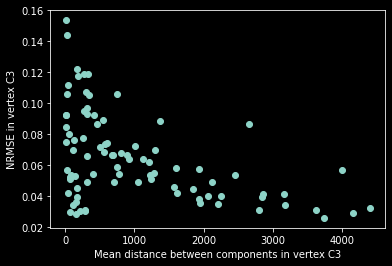

In [172]:
plt.scatter(itemgetter(*index)(c3_dist), itemgetter(*index)(mean_rmse_c3))
plt.xlabel('Mean distance between components in vertex C3')
plt.ylabel('NRMSE in vertex C3')

In [194]:
acc_component = []
roc_auc_component = []
for i in range(300):
    mean = means[i]
    cov = covs[i]
    model = GMM(n_components=3, priors=w, means=mean, covariances=cov)
    sample = model.sample(1000)
    model_new = GaussianMixture(n_components=3).fit(sample)
    real_data = real_iter[i]
    pred_data = pred_iter[i]
    real_mark = []
    pred_mark = []
    min_length = np.min([len(real_data[0]), len(real_data[1]), len(real_data[2])])
    real_df = pd.DataFrame(columns=['C1', 'C2', 'C3'])
    real_df['C1'] = real_data[0][0:min_length]
    real_df['C2'] = real_data[1][0:min_length]
    real_df['C3'] = real_data[2][0:min_length]
    pred_df = pd.DataFrame(columns=['C1', 'C2', 'C3'])
    pred_df['C1'] = pred_data[0][0:min_length]
    pred_df['C2'] = pred_data[1][0:min_length]
    pred_df['C3'] = pred_data[2][0:min_length]
    real_mark = model_new.predict(real_df.values)
    pred_mark = model_new.predict(pred_df.values)
    # for i in model.to_responsibilities(real_df.values):
    #     real_mark.append(i.argmax())
    # for i in model.to_responsibilities(pred_df.values):
    #     pred_mark.append(i.argmax())
    #     pred_prob.append(i)
    acc_component.append(accuracy_score(real_mark, pred_mark))
    
   
        


In [92]:
acc_component_simple = []

for i in range(300):
    mean = means[i]
    cov = covs[i]
    model = GMM(n_components=3, priors=w, means=mean, covariances=cov)
    sample = model.sample(1000)
    model_new = GaussianMixture(n_components=3).fit(sample)
    real_data = real_simple[i]
    pred_data = pred_simple[i]
    real_mark = []
    pred_mark = []
    min_length = np.min([len(real_data[0]), len(real_data[1]), len(real_data[2])])
    real_df = pd.DataFrame(columns=['C1', 'C2', 'C3'])
    real_df['C1'] = real_data[0][0:min_length]
    real_df['C2'] = real_data[1][0:min_length]
    real_df['C3'] = real_data[2][0:min_length]
    pred_df = pd.DataFrame(columns=['C1', 'C2', 'C3'])
    pred_df['C1'] = pred_data[0][0:min_length]
    pred_df['C2'] = pred_data[1][0:min_length]
    pred_df['C3'] = pred_data[2][0:min_length]
    real_mark = model_new.predict(real_df.values)
    pred_mark = model_new.predict(pred_df.values)
    # for i in model.to_responsibilities(real_df.values):
    #     real_mark.append(i.argmax())
    # for i in model.to_responsibilities(pred_df.values):
    #     pred_mark.append(i.argmax())
    #     pred_prob.append(i)
    acc_component_simple.append(accuracy_score(real_mark, pred_mark))
    

Text(0, 0.5, 'Acc component')

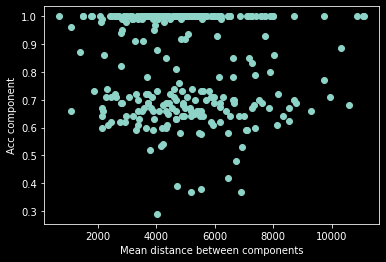

In [195]:
plt.scatter(mean_components_dist, acc_component)
plt.xlabel('Mean distance between components')
plt.ylabel('Acc component')

Text(0, 0.5, 'Acc component')

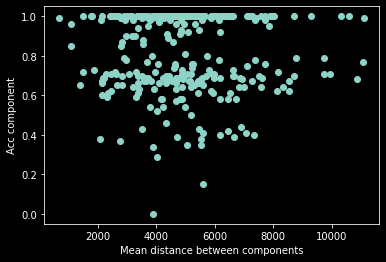

In [93]:
plt.scatter(mean_components_dist, acc_component_simple)
plt.xlabel('Mean distance between components')
plt.ylabel('Acc component')

## Пример расчёта расстояния через линейный дискриминант 

In [205]:
clf = LinearDiscriminantAnalysis(solver='eigen')
mean = means[0]
cov = covs[0]
model = GMM(n_components=3, priors=w, means=mean, covariances=cov)
sample = model.sample(1000)
y = []
for i in model.to_responsibilities(sample):
    y.append(i.argmax())
clf.fit(sample, y)


LinearDiscriminantAnalysis(solver='eigen')

In [4]:
def discriminant_distance(x1, x2, U):
    diff = x1 - x2
    diff_t = np.transpose(diff)
    U_t = np.transpose(U)
    UU = np.dot(U,U_t)
    d = np.dot(np.dot(diff_t, UU), diff)
    return d


In [201]:
sample = pd.DataFrame(data=sample, columns=['C1', 'C2', 'C3'])
sample['c'] = y 
x1 = sample.loc[sample['c'] == 0][['C1', 'C2', 'C3']].values
x2 = sample.loc[sample['c'] == 1][['C1', 'C2', 'C3']].values
x3 = sample.loc[sample['c'] == 2][['C1', 'C2', 'C3']].values
length = []
length.append(len(x1))
length.append(len(x2))
length.append(len(x3))
min_len = np.min(length)
x1 = np.transpose(x1[0:min_len])
x2 = np.transpose(x2[0:min_len])
x3 = np.transpose(x3[0:min_len])

dist_matrix12d = np.empty([min_len, min_len])
dist_matrix13d = np.empty([min_len, min_len])
dist_matrix23d = np.empty([min_len, min_len])
for i in range(min_len):
    for j in range(min_len):
        X1 = np.array([[x1[0][i]], [x1[1][i]], [x1[2][i]]])
        X2 = np.array([[x2[0][i]], [x2[1][i]],  [x2[2][i]]])
        X3 = np.array([[x3[0][i]], [x3[1][i]], [x3[2][i]]])
        dist_matrix12d[i][j] = discriminant_distance(X1, X2, clf.coef_)
        dist_matrix13d[i][j] = discriminant_distance(X1, X3, clf.coef_)
        dist_matrix23d[i][j] = discriminant_distance(X2, X3, clf.coef_)
(np.mean(dist_matrix12d) + np.mean(dist_matrix13d) + np.mean(dist_matrix23d)) / 3

10066817.130778044

In [207]:
mean_discr_distance = []
for i in range(300):
    print(i)
    mean = means[i]
    cov = covs[i]
    model = GMM(n_components=3, priors=w, means=mean, covariances = cov)
    sample = model.sample(500)
    clf = LinearDiscriminantAnalysis(solver='eigen')
    y = []
    for i in model.to_responsibilities(sample):
        y.append(i.argmax())
    clf.fit(sample, y)
    sample = pd.DataFrame(data=sample, columns=['C1', 'C2', 'C3'])
    sample['c'] = y 
    x1 = sample.loc[sample['c'] == 0][['C1', 'C2', 'C3']].values
    x2 = sample.loc[sample['c'] == 1][['C1', 'C2', 'C3']].values
    x3 = sample.loc[sample['c'] == 2][['C1', 'C2', 'C3']].values
    length = []
    length.append(len(x1))
    length.append(len(x2))
    length.append(len(x3))
    min_len = np.min(length)
    x1 = np.transpose(x1[0:min_len])
    x2 = np.transpose(x2[0:min_len])
    x3 = np.transpose(x3[0:min_len])

    dist_matrix12d = np.empty([min_len, min_len])
    dist_matrix13d = np.empty([min_len, min_len])
    dist_matrix23d = np.empty([min_len, min_len])
    for i in range(min_len):
        for j in range(min_len):
            X1 = np.array([[x1[0][i]], [x1[1][i]], [x1[2][i]]])
            X2 = np.array([[x2[0][i]], [x2[1][i]],  [x2[2][i]]])
            X3 = np.array([[x3[0][i]], [x3[1][i]], [x3[2][i]]])
            dist_matrix12d[i][j] = discriminant_distance(X1, X2, clf.covariance_)
            dist_matrix13d[i][j] = discriminant_distance(X1, X3, clf.covariance_)
            dist_matrix23d[i][j] = discriminant_distance(X2, X3, clf.covariance_)
    mean_discr_distance.append((np.mean(dist_matrix12d) + np.mean(dist_matrix13d) + np.mean(dist_matrix23d)) / 3)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Text(0, 0.5, 'Mean NRMSE')

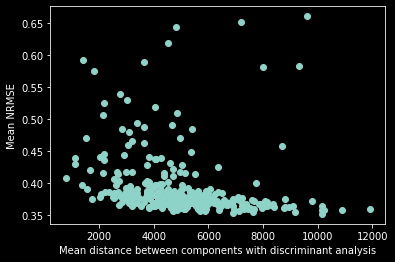

In [209]:
plt.scatter(mean_discr_distance, mean_rmse)
plt.xlabel('Mean distance between components with discriminant analysis')
plt.ylabel('Mean NRMSE')

## Генерация данных в каждом узле сети 

In [6]:
distance_vertex = []
means_vertex = []
covs_vertex = []

for _ in range(300):
    print(_)
    mean = []
    cov = []
    dists = []
    for v in range(5):
        m = []
        c = []
        comp = 0
        w = []
        
        if (v == 0) | (v == 2):
            comp = 2
            w = [1/2, 1/2]
        if (v == 1) | (v == 3):
            comp = 3
            w = [1/3, 1/3, 1/3]
        if v == 4:
            comp = 4
            w = [1/4, 1/4, 1/4, 1/4]
        for k in range(comp):
            if k == 0:
                m.append([random.randint(0, 125)])
                c.append([[5]]) 
            if k == 1:
                m.append([random.randint(125, 250)])
                c.append([[5]]) 
            if k == 2:
                m.append([random.randint(250, 375)])
                c.append([[5]]) 
            if k == 3:
                m.append([random.randint(375, 500)])
                c.append([[5]]) 
        mean.append(m)
        cov.append(c)
        model = GMM(n_components=comp, priors = w, means = m, covariances=c)
        sample = model.sample(1000)
        cat = []
        for i in model.to_responsibilities(sample):
            cat.append(i.argmax())
        clf = LinearDiscriminantAnalysis(solver='eigen').fit(sample, cat)
        sample = pd.DataFrame(data=sample, columns = ['C'+str(v)])
        sample['comp'] = cat
        if (v == 0) | (v == 2):
            x1 = sample.loc[sample['comp'] == 0]['C'+str(v)].values
            x2 = sample.loc[sample['comp'] == 1]['C'+str(v)].values
            min_len = np.min([len(x1), len(x2)])
            x1 = np.transpose(x1[0:min_len])
            x2 = np.transpose(x2[0:min_len])
            dist12 = np.empty([min_len, min_len])
            for i in range(min_len):
                for j in range(min_len):
                    X1 = np.array([[x1[i]]])
                    X2 = np.array([[x2[j]]])
                    dist12[i][j] = discriminant_distance(X1, X2, clf.covariance_)
            dists.append(np.mean(dist12))
        if (v == 1) | (v == 3):
            x1 = sample.loc[sample['comp'] == 0]['C'+str(v)].values
            x2 = sample.loc[sample['comp'] == 1]['C'+str(v)].values
            x3 = sample.loc[sample['comp'] == 2]['C'+str(v)].values
            min_len = np.min([len(x1), len(x2), len(x3)])
            x1 = np.transpose(x1[0:min_len])
            x2 = np.transpose(x2[0:min_len])
            x3 = np.transpose(x3[0:min_len])
            dist12 = np.empty([min_len, min_len])
            dist23 = np.empty([min_len, min_len])
            dist13 = np.empty([min_len, min_len])
            for i in range(min_len):
                for j in range(min_len):
                    X1 = np.array([[x1[i]]])
                    X2 = np.array([[x2[j]]])
                    Y2 = np.array([[x2[i]]])
                    X3 = np.array([[x3[j]]])
                    dist12[i][j] = discriminant_distance(X1, X2, clf.covariance_)
                    dist23[i][j] = discriminant_distance(Y2, X3, clf.covariance_)
                    dist13[i][j] = discriminant_distance(X1, X3, clf.covariance_)
            dists.append((np.mean(dist12) + np.mean(dist23) + np.mean(dist13)) / 3)
        if v == 4:
            x1 = sample.loc[sample['comp'] == 0]['C'+str(v)].values
            x2 = sample.loc[sample['comp'] == 1]['C'+str(v)].values
            x3 = sample.loc[sample['comp'] == 2]['C'+str(v)].values
            x4 = sample.loc[sample['comp'] == 3]['C'+str(v)].values
            min_len = np.min([len(x1), len(x2), len(x3), len(x4)])
            x1 = np.transpose(x1[0:min_len])
            x2 = np.transpose(x2[0:min_len])
            x3 = np.transpose(x3[0:min_len])
            x4 = np.transpose(x4[0:min_len])
            dist12 = np.empty([min_len, min_len])
            dist23 = np.empty([min_len, min_len])
            dist13 = np.empty([min_len, min_len])
            dist14 = np.empty([min_len, min_len])
            dist24 = np.empty([min_len, min_len])
            dist34 = np.empty([min_len, min_len])
            for i in range(min_len):
                for j in range(min_len):
                    X1 = np.array([[x1[i]]])
                    X2 = np.array([[x2[j]]])
                    Y2 = np.array([[x2[i]]])
                    X3 = np.array([[x3[i]]])
                    Y3 = np.array([[x3[j]]])
                    X4 = np.array([[x4[j]]])
                    dist12[i][j] = discriminant_distance(X1, X2, clf.covariance_)
                    dist23[i][j] = discriminant_distance(Y2, Y3, clf.covariance_)
                    dist13[i][j] = discriminant_distance(X1, Y3, clf.covariance_)
                    dist14[i][j] = discriminant_distance(X1, X4, clf.covariance_)
                    dist24[i][j] = discriminant_distance(Y2, X4, clf.covariance_)
                    dist34[i][j] = discriminant_distance(X3, X4, clf.covariance_)
            dists.append((np.mean(dist12) + np.mean(dist23) + np.mean(dist13) + np.mean(dist14) + np.mean(dist24) + np.mean(dist34)) / 6)
    distance_vertex.append(dists)    
    means_vertex.append(mean)
    covs_vertex.append(cov)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [8]:
node_types = {'C1':'cont', 'C2':'cont', 'C3':'cont', 'C4':'cont', 'C5':'cont'}
columns_for_disc = ['C1', 'C2', 'C3', 'C4', 'C5']
rmse_vertrex = []
samples_train_vertex = []
samples_test_vertex = []
real_vertex = []
pred_vertex = []
for i in range(300):
    print(i)
    mean = means_vertex[i]
    cov = covs_vertex[i]
    sample = pd.DataFrame()
    for v in range(5):
        model = GMM(n_components=len(mean[v]), priors=[1/wi for wi in [len(mean[v])]*len(mean[v])], means=mean[v], covariances=cov[v])
        sample['C'+str(v+1)] = [z[0] for z in model.sample(5000)]
    train, test = train_test_split(sample, test_size=0.02)
    train.reset_index(inplace=True, drop=True)
    test.reset_index(inplace=True, drop=True)
    samples_train_vertex.append(train)
    samples_test_vertex.append(test)
    discrete, coder = discretization(train, 'equal_frequency', columns_for_disc)
    bn = structure_learning(discrete, 'HC', node_types, 'K2')
    params = parameter_learning(train, node_types, bn, 'mix')
    save_structure(bn, 'all_net')
    skel = read_structure('all_net')
    save_params(params, 'all_net_param')
    params = read_params('all_net_param')
    all_bn = HyBayesianNetwork(skel, params)
    acc, rmse, real, pred, index = parall_accuracy(all_bn, test, columns_for_disc, 'mix', cpu_count)
    real_vertex.append(real)
    pred_vertex.append(pred)
    rmse_vertrex.append(rmse)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [175]:
distance_c1 = []
for i in range(300):
    distance_c1.append(distance_vertex[i][4])

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

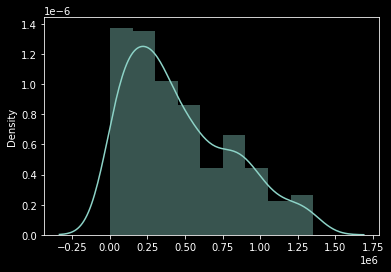

In [10]:
sns.distplot(distance_c1)

In [129]:
rmse_c1 = []
for i in range(300):
    d = rmse_vertrex[i]
    rmse_c1.append(d['C5'] / np.std(real_vertex[i][4]))

Text(0, 0.5, 'NRMSE C5')

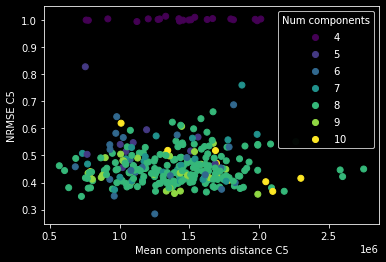

In [133]:
fig, ax = plt.subplots()

scatter = ax.scatter(distance_c1, rmse_c1, c=num_component)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Num components")
ax.add_artist(legend1)
ax.set_xlabel('Mean components distance C5')
ax.set_ylabel('NRMSE C5')


In [25]:
node_types = {'C1':'cont', 'C2':'cont', 'C3':'cont', 'C4':'cont', 'C5':'cont'}
columns_for_disc = ['C1', 'C2', 'C3', 'C4', 'C5']
rmse_simple = []
real_simple = []
pred_simple = []
for i in range(300):
    print(i)
    train = samples_train_vertex[i]
    test = samples_test_vertex[i]
    discrete_data, coder = discretization(train, 'equal_frequency', columns_for_disc)
    bn_full = structure_learning(discrete_data, 'HC', node_types, 'K2')
    params = parameter_learning(train, node_types, bn_full, 'simple')
    save_structure(bn_full, 'all_net')
    skel = read_structure('all_net')
    save_params(params, 'all_net_param')
    params = read_params('all_net_param')
    all_bn = HyBayesianNetwork(skel, params)
    acc, rmse, real, pred, index = parall_accuracy(all_bn, test, columns_for_disc, 'simple', cpu_count)
    real_simple.append(real)
    pred_simple.append(pred)
    rmse_simple.append(rmse)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [45]:
rmse_decrease = []
for i in range(300):
    r1 = rmse_vertrex[i]['C1'] / np.std(real_vertex[i][0])
    r2 = rmse_vertrex[i]['C2'] / np.std(real_vertex[i][1])
    r3 = rmse_vertrex[i]['C3'] / np.std(real_vertex[i][2])
    r4 = rmse_vertrex[i]['C4'] / np.std(real_vertex[i][3])
    r5 = rmse_vertrex[i]['C5'] / np.std(real_vertex[i][4])

    r1s = rmse_simple[i]['C1'] /  np.std(real_simple[i][0])
    r2s = rmse_simple[i]['C2'] / np.std(real_simple[i][1])
    r3s = rmse_simple[i]['C3'] / np.std(real_simple[i][2])
    r4s = rmse_simple[i]['C4'] / np.std(real_simple[i][3])
    r5s = rmse_simple[i]['C5'] / np.std(real_simple[i][4])



    decrease1 = 100 - ((r1 * 100) / r1s)
    decrease2 = 100 - ((r2 * 100) / r2s)
    decrease3 = 100 - ((r3 * 100) / r3s)
    decrease4 = 100 - ((r4 * 100) / r4s)
    decrease5 = 100 - ((r5 * 100) / r5s)
    rmse_decrease.append(decrease5)

Text(0, 0.5, 'NRMSE decrease %')

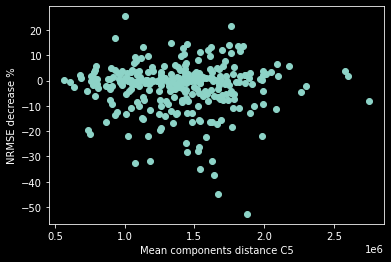

In [46]:
plt.scatter(distance_c1, rmse_decrease)
plt.xlabel('Mean components distance C5')
plt.ylabel('NRMSE decrease %')

In [47]:
node_types = {'C1':'cont', 'C2':'cont', 'C3':'cont', 'C4':'cont', 'C5':'cont'}
columns_for_disc = ['C1', 'C2', 'C3', 'C4', 'C5']
structures = []
for i in range(300):
    print(i)
    train = samples_train_vertex[i]
    discrete_data, coder = discretization(train, 'equal_frequency', columns_for_disc)
    bn_full = structure_learning(discrete_data, 'HC', node_types, 'K2')
    structures.append(bn_full['E'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [59]:
uniq_structures = dict()
n = 0
for s in structures:
    if str(s) not in list(uniq_structures.keys()):
        uniq_structures[str(s)] = n
        n += 1

In [61]:
color = []
for i in range(300):
    color.append(uniq_structures[str(structures[i])])

In [131]:
vertrex_parent = []
labels = []
for i in range(300):
    p = 0
    for pair in structures[i]:
        if ('C5' in pair) & (pair[1] == 'C5'):
            p+= 1
    vertrex_parent.append(p)
    labels.append(str(p))


In [145]:
num_component = []
for i in range(300):
    print(i)
    if vertrex_parent[i] == 0:
        num_component.append(int(((component(samples_train_vertex[i], ['C5'], 'aic')) + (component(samples_train_vertex[i], ['C5'], 'bic'))) / 2))
    else:
        parents = []
        for pair in structures[i]:
            if ('C5' in pair) & (pair[1] == 'C5'):
                parents.append(pair[0])
        n = int(((component(samples_train_vertex[i], ['C5']+parents, 'aic')) + (component(samples_train_vertex[i], ['C5']+parents, 'bic'))) / 2)
        num_component.append(n)



0
1
2
3
4


KeyboardInterrupt: 

In [174]:
acc = []
for i in range(300):
    m = means_vertex[i][4]
    c = covs_vertex[i][4]
    w = [1/4, 1/4, 1/4, 1/4]
    model = GMM(n_components=4, priors=w, means=m, covariances=c)
    real_mark = []
    pred_mark = []
    real_df = pd.DataFrame(data = real_vertex[i][4], columns=['C5'])
    pred_df = pd.DataFrame(data = pred_vertex[i][4], columns=['C5'])
    for j in model.to_responsibilities(real_df[['C5']].values):
        real_mark.append(j.argmax())
    for j in model.to_responsibilities(pred_df[['C5']].values):
        pred_mark.append(j.argmax())
    acc.append(accuracy_score(real_mark, pred_mark))
    
        

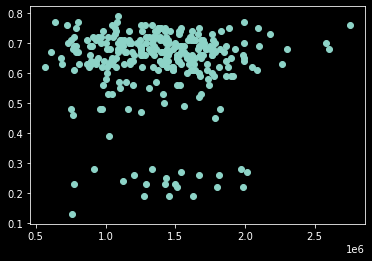

In [176]:
plt.scatter(distance_c1, acc)

## Моделирование разных смесей с более тщательным моделированием области с малыми расстояниями

In [15]:
dist_matrix = []
means = []
covs = []
w = [1/3, 1/3, 1/3]
for _ in range(100):
    print(_)
    mean = []
    cov = []
    for k in range(3):
        if k == 0:
            mean.append([random.randint(0, 10), random.randint(0, 10), random.randint(0, 10)])
        if k == 1:
            mean.append([random.randint(0, 10), random.randint(0, 10), random.randint(0, 10)])
        if k == 2:
            mean.append([random.randint(0, 10), random.randint(0, 10), random.randint(0, 10)])
        cov.append(np.array([[ 1, 0, 0],
       [0,  1,  0],
       [0,  0,  1]]))
       
    model = GMM(n_components=3, priors=w, means=mean, covariances=cov)
    sample = model.sample(500)
    sample = pd.DataFrame(data = sample, columns=['C1', 'C2', 'C3'])
    means.append(mean)
    covs.append(cov)
    c = []
    for i in model.to_responsibilities(sample):
        c.append(i.argmax())
    clf = LinearDiscriminantAnalysis(solver='eigen').fit(sample, c)
    sample['comp'] = c
    x1 = sample.loc[sample['comp'] == 0][['C1', 'C2', 'C3']].values
    x2 = sample.loc[sample['comp'] == 1][['C1', 'C2', 'C3']].values
    x3 = sample.loc[sample['comp'] == 2][['C1', 'C2', 'C3']].values
    length = []
    length.append(len(x1))
    length.append(len(x2))
    length.append(len(x3))
    min_len = np.min(length)
    x1 = np.transpose(x1[0:min_len])
    x2 = np.transpose(x2[0:min_len])
    x3 = np.transpose(x3[0:min_len])
    dist_matrix12 = np.empty([min_len, min_len])
    dist_matrix13 = np.empty([min_len, min_len])
    dist_matrix23 = np.empty([min_len, min_len])
    for i in range(min_len):
        for j in range(min_len):
            X1 = np.array([[x1[0][i]], [x1[1][i]], [x1[2][i]]])
            X2 = np.array([[x2[0][i]], [x2[1][i]],  [x2[2][i]]])
            Y2 = np.array([[x2[0][j]], [x2[1][j]], [x2[2][j]]])
            Y3 = np.array([[x3[0][j]], [x3[1][j]], [x3[2][j]]])
            dist_matrix12[i][j] = math.sqrt(discriminant_distance(X1, Y2, clf.covariance_))
            dist_matrix13[i][j] = math.sqrt(discriminant_distance(X1, Y3, clf.covariance_))
            dist_matrix23[i][j] = math.sqrt(discriminant_distance(X2, Y3, clf.covariance_))
    
    dist_matrix.append((np.mean(dist_matrix12) + np.mean(dist_matrix13) + np.mean(dist_matrix23)) / 3)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

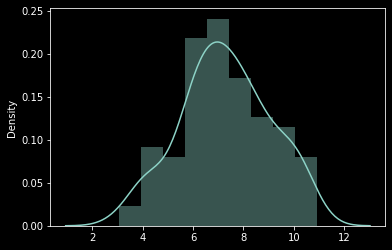

In [6]:
sns.distplot(dist_matrix)

In [16]:
for _ in range(100):
    print(_)
    mean = []
    cov = []
    for k in range(3):
        if k == 0:
            mean.append([random.randint(0, 10), random.randint(0, 10), random.randint(0, 10)])
        if k == 1:
            mean.append([random.randint(20, 30), random.randint(20, 30), random.randint(20, 30)])
        if k == 2:
            mean.append([random.randint(40, 60), random.randint(40, 60), random.randint(40, 60)])
        cov.append(np.array([[ 1, 0, 0],
       [0,  1,  0],
       [0,  0,  1]]))
    model = GMM(n_components=3, priors=w, means=mean, covariances=cov)
    sample = model.sample(500)
    sample = pd.DataFrame(data = sample, columns=['C1', 'C2', 'C3'])
    means.append(mean)
    covs.append(cov)
    c = []
    for i in model.to_responsibilities(sample):
        c.append(i.argmax())
    clf = LinearDiscriminantAnalysis(solver='eigen').fit(sample, c)
    sample['comp'] = c
    x1 = sample.loc[sample['comp'] == 0][['C1', 'C2', 'C3']].values
    x2 = sample.loc[sample['comp'] == 1][['C1', 'C2', 'C3']].values
    x3 = sample.loc[sample['comp'] == 2][['C1', 'C2', 'C3']].values
    length = []
    length.append(len(x1))
    length.append(len(x2))
    length.append(len(x3))
    min_len = np.min(length)
    x1 = np.transpose(x1[0:min_len])
    x2 = np.transpose(x2[0:min_len])
    x3 = np.transpose(x3[0:min_len])
    dist_matrix12 = np.empty([min_len, min_len])
    dist_matrix13 = np.empty([min_len, min_len])
    dist_matrix23 = np.empty([min_len, min_len])
    for i in range(min_len):
        for j in range(min_len):
            X1 = np.array([[x1[0][i]], [x1[1][i]], [x1[2][i]]])
            X2 = np.array([[x2[0][i]], [x2[1][i]],  [x2[2][i]]])
            Y2 = np.array([[x2[0][j]], [x2[1][j]], [x2[2][j]]])
            Y3 = np.array([[x3[0][j]], [x3[1][j]], [x3[2][j]]])
            dist_matrix12[i][j] = math.sqrt(discriminant_distance(X1, Y2, clf.covariance_))
            dist_matrix13[i][j] = math.sqrt(discriminant_distance(X1, Y3, clf.covariance_))
            dist_matrix23[i][j] = math.sqrt(discriminant_distance(X2, Y3, clf.covariance_))
    
    dist_matrix.append((np.mean(dist_matrix12) + np.mean(dist_matrix13) + np.mean(dist_matrix23)) / 3)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

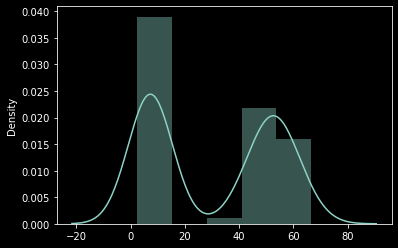

In [17]:
sns.distplot(dist_matrix)

In [18]:
for _ in range(100):
    print(_)
    mean = []
    cov = []
    for k in range(3):
        if k == 0:
            mean.append([random.randint(0, 10), random.randint(0, 10), random.randint(0, 10)])
        if k == 1:
            mean.append([random.randint(60, 70), random.randint(60, 70), random.randint(60, 70)])
        if k == 2:
            mean.append([random.randint(150, 160), random.randint(150, 160), random.randint(150, 160)])
       
        cov.append(np.array([[ 1, 0, 0],
       [0,  1,  0],
       [0,  0,  1]]))
        
    model = GMM(n_components=3, priors=w, means=mean, covariances=cov)
    sample = model.sample(500)
    sample = pd.DataFrame(data = sample, columns=['C1', 'C2', 'C3'])
    
    means.append(mean)
    covs.append(cov)
    
   
    c = []
    for i in model.to_responsibilities(sample):
        c.append(i.argmax())
    clf = LinearDiscriminantAnalysis(solver='eigen').fit(sample, c)
    sample['comp'] = c
    x1 = sample.loc[sample['comp'] == 0][['C1', 'C2', 'C3']].values
    x2 = sample.loc[sample['comp'] == 1][['C1', 'C2', 'C3']].values
    x3 = sample.loc[sample['comp'] == 2][['C1', 'C2', 'C3']].values
    length = []
    length.append(len(x1))
    length.append(len(x2))
    length.append(len(x3))
    min_len = np.min(length)
    x1 = np.transpose(x1[0:min_len])
    x2 = np.transpose(x2[0:min_len])
    x3 = np.transpose(x3[0:min_len])
    dist_matrix12 = np.empty([min_len, min_len])
    dist_matrix13 = np.empty([min_len, min_len])
    dist_matrix23 = np.empty([min_len, min_len])
    for i in range(min_len):
        for j in range(min_len):
            X1 = np.array([[x1[0][i]], [x1[1][i]], [x1[2][i]]])
            X2 = np.array([[x2[0][i]], [x2[1][i]],  [x2[2][i]]])
            Y2 = np.array([[x2[0][j]], [x2[1][j]], [x2[2][j]]])
            Y3 = np.array([[x3[0][j]], [x3[1][j]], [x3[2][j]]])
            dist_matrix12[i][j] = math.sqrt(discriminant_distance(X1, Y2, clf.covariance_))
            dist_matrix13[i][j] = math.sqrt(discriminant_distance(X1, Y3, clf.covariance_))
            dist_matrix23[i][j] = math.sqrt(discriminant_distance(X2, Y3, clf.covariance_))
    
    dist_matrix.append((np.mean(dist_matrix12) + np.mean(dist_matrix13) + np.mean(dist_matrix23)) / 3)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

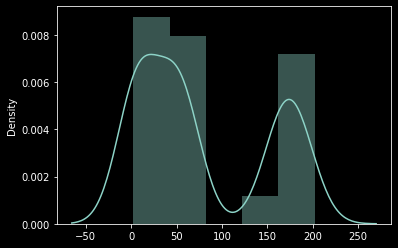

In [19]:
sns.distplot(dist_matrix)

In [20]:
for _ in range(100):
    print(_)
    mean = []
    cov = []
    for k in range(3):
        if k == 0:
            mean.append([random.randint(0, 10), random.randint(0, 10), random.randint(0, 10)])
        if k == 1:
            mean.append([random.randint(100, 110), random.randint(100, 110), random.randint(100, 110)])
        if k == 2:
            mean.append([random.randint(300, 310), random.randint(300, 310), random.randint(300, 310)])
        
        cov.append(np.array([[ 1, 0, 0],
       [0,  1,  0],
       [0,  0,  1]]))
       
    model = GMM(n_components=3, priors=w, means=mean, covariances=cov)
    sample = model.sample(500)
    sample = pd.DataFrame(data = sample, columns=['C1', 'C2', 'C3'])
   
    means.append(mean)
    covs.append(cov)
   
    c = []
    for i in model.to_responsibilities(sample):
        c.append(i.argmax())
    clf = LinearDiscriminantAnalysis(solver='eigen').fit(sample, c)
    sample['comp'] = c
    x1 = sample.loc[sample['comp'] == 0][['C1', 'C2', 'C3']].values
    x2 = sample.loc[sample['comp'] == 1][['C1', 'C2', 'C3']].values
    x3 = sample.loc[sample['comp'] == 2][['C1', 'C2', 'C3']].values
    length = []
    length.append(len(x1))
    length.append(len(x2))
    length.append(len(x3))
    min_len = np.min(length)
    x1 = np.transpose(x1[0:min_len])
    x2 = np.transpose(x2[0:min_len])
    x3 = np.transpose(x3[0:min_len])
    dist_matrix12 = np.empty([min_len, min_len])
    dist_matrix13 = np.empty([min_len, min_len])
    dist_matrix23 = np.empty([min_len, min_len])
    for i in range(min_len):
        for j in range(min_len):
            X1 = np.array([[x1[0][i]], [x1[1][i]], [x1[2][i]]])
            X2 = np.array([[x2[0][i]], [x2[1][i]],  [x2[2][i]]])
            Y2 = np.array([[x2[0][j]], [x2[1][j]], [x2[2][j]]])
            Y3 = np.array([[x3[0][j]], [x3[1][j]], [x3[2][j]]])
            dist_matrix12[i][j] = math.sqrt(discriminant_distance(X1, Y2, clf.covariance_))
            dist_matrix13[i][j] = math.sqrt(discriminant_distance(X1, Y3, clf.covariance_))
            dist_matrix23[i][j] = math.sqrt(discriminant_distance(X2, Y3, clf.covariance_))
    
    dist_matrix.append((np.mean(dist_matrix12) + np.mean(dist_matrix13) + np.mean(dist_matrix23)) / 3)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

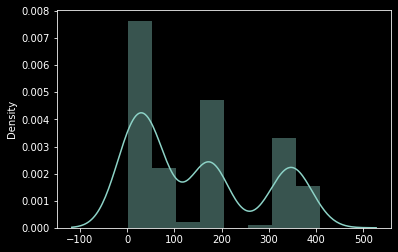

In [21]:
sns.distplot(dist_matrix)

In [22]:
for _ in range(100):
    print(_)
    mean = []
    cov = []
    for k in range(3):
        if k == 0:
            mean.append([random.randint(80, 100), random.randint(80, 100), random.randint(80, 100)])
        if k == 1:
            mean.append([random.randint(500, 600), random.randint(500, 600), random.randint(500, 600)])
        if k == 2:
            mean.append([random.randint(800, 1000), random.randint(800, 1000), random.randint(800, 1000)])
       
        cov.append(np.array([[ 1, 0, 0],
       [0,  1,  0],
       [0,  0,  1]]))
       
    model = GMM(n_components=3, priors=w, means=mean, covariances=cov)
    sample = model.sample(500)
    sample = pd.DataFrame(data = sample, columns=['C1', 'C2', 'C3'])
   
    means.append(mean)
    covs.append(cov)
   
    c = []
    for i in model.to_responsibilities(sample):
        c.append(i.argmax())
    clf = LinearDiscriminantAnalysis(solver='eigen').fit(sample, c)
    sample['comp'] = c
    x1 = sample.loc[sample['comp'] == 0][['C1', 'C2', 'C3']].values
    x2 = sample.loc[sample['comp'] == 1][['C1', 'C2', 'C3']].values
    x3 = sample.loc[sample['comp'] == 2][['C1', 'C2', 'C3']].values
    length = []
    length.append(len(x1))
    length.append(len(x2))
    length.append(len(x3))
    min_len = np.min(length)
    x1 = np.transpose(x1[0:min_len])
    x2 = np.transpose(x2[0:min_len])
    x3 = np.transpose(x3[0:min_len])
    dist_matrix12 = np.empty([min_len, min_len])
    dist_matrix13 = np.empty([min_len, min_len])
    dist_matrix23 = np.empty([min_len, min_len])
    for i in range(min_len):
        for j in range(min_len):
            X1 = np.array([[x1[0][i]], [x1[1][i]], [x1[2][i]]])
            X2 = np.array([[x2[0][i]], [x2[1][i]],  [x2[2][i]]])
            Y2 = np.array([[x2[0][j]], [x2[1][j]], [x2[2][j]]])
            Y3 = np.array([[x3[0][j]], [x3[1][j]], [x3[2][j]]])
            dist_matrix12[i][j] = math.sqrt(discriminant_distance(X1, Y2, clf.covariance_))
            dist_matrix13[i][j] = math.sqrt(discriminant_distance(X1, Y3, clf.covariance_))
            dist_matrix23[i][j] = math.sqrt(discriminant_distance(X2, Y3, clf.covariance_))
    
    dist_matrix.append((np.mean(dist_matrix12) + np.mean(dist_matrix13) + np.mean(dist_matrix23)) / 3)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

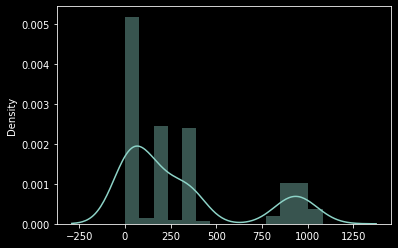

In [23]:
sns.distplot(dist_matrix)

In [26]:
for _ in range(100):
    print(_)
    mean = []
    cov = []
    for k in range(3):
        if k == 0:
            mean.append([random.randint(80, 100), random.randint(80, 100), random.randint(80, 100)])
        if k == 1:
            mean.append([random.randint(1000, 1100), random.randint(1000, 1100), random.randint(1000, 1100)])
        if k == 2:
            mean.append([random.randint(2000, 2100), random.randint(2000, 2100), random.randint(2000, 2100)])
        
        cov.append(np.array([[ 1, 0, 0],
       [0,  1,  0],
       [0,  0,  1]]))
       
    model = GMM(n_components=3, priors=w, means=mean, covariances=cov)
    sample = model.sample(500)
    sample = pd.DataFrame(data = sample, columns=['C1', 'C2', 'C3'])
    
    means.append(mean)
    covs.append(cov)
   
   
    c = []
    for i in model.to_responsibilities(sample):
        c.append(i.argmax())
    clf = LinearDiscriminantAnalysis(solver='eigen').fit(sample, c)
    sample['comp'] = c
    x1 = sample.loc[sample['comp'] == 0][['C1', 'C2', 'C3']].values
    x2 = sample.loc[sample['comp'] == 1][['C1', 'C2', 'C3']].values
    x3 = sample.loc[sample['comp'] == 2][['C1', 'C2', 'C3']].values
    length = []
    length.append(len(x1))
    length.append(len(x2))
    length.append(len(x3))
    min_len = np.min(length)
    x1 = np.transpose(x1[0:min_len])
    x2 = np.transpose(x2[0:min_len])
    x3 = np.transpose(x3[0:min_len])
    dist_matrix12 = np.empty([min_len, min_len])
    dist_matrix13 = np.empty([min_len, min_len])
    dist_matrix23 = np.empty([min_len, min_len])
    for i in range(min_len):
        for j in range(min_len):
            X1 = np.array([[x1[0][i]], [x1[1][i]], [x1[2][i]]])
            X2 = np.array([[x2[0][i]], [x2[1][i]],  [x2[2][i]]])
            Y2 = np.array([[x2[0][j]], [x2[1][j]], [x2[2][j]]])
            Y3 = np.array([[x3[0][j]], [x3[1][j]], [x3[2][j]]])
            dist_matrix12[i][j] = math.sqrt(discriminant_distance(X1, Y2, clf.covariance_))
            dist_matrix13[i][j] = math.sqrt(discriminant_distance(X1, Y3, clf.covariance_))
            dist_matrix23[i][j] = math.sqrt(discriminant_distance(X2, Y3, clf.covariance_))
    
    dist_matrix.append((np.mean(dist_matrix12) + np.mean(dist_matrix13) + np.mean(dist_matrix23)) / 3)

0
1
2
3
4
5


KeyboardInterrupt: 

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

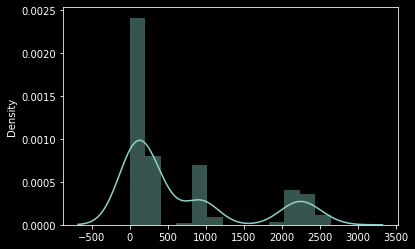

In [27]:
sns.distplot(dist_matrix)

In [16]:
node_types = {'C1':'cont', 'C2':'cont', 'C3':'cont'}
columns_for_disc = ['C1', 'C2', 'C3']
rmse_all_column = []
structures = []
samples_train = []
samples_test = []
real_iter = []
pred_iter = []
for i in range(400):
    print(i)
    mean = means[i]
    cov = covs[i]
    model = GMM(n_components=3, priors=w, means=mean, covariances=cov)
    sample = model.sample(5000)
    sample = pd.DataFrame(data = sample, columns=['C1', 'C2', 'C3'])
    train, test = train_test_split(sample, test_size=0.02)
    train.reset_index(inplace=True, drop=True)
    test.reset_index(inplace=True, drop=True)
    samples_train.append(train)
    samples_test.append(test)
    discrete_data, coder = discretization(train, 'equal_frequency', columns_for_disc)
    bn_full = structure_learning(discrete_data, 'HC', node_types, 'K2')
    structures.append(bn_full['E'])
    params = parameter_learning(train, node_types, bn_full, 'mix')
    save_structure(bn_full, 'all_net')
    skel = read_structure('all_net')
    save_params(params, 'all_net_param')
    params = read_params('all_net_param')
    all_bn = HyBayesianNetwork(skel, params)
    acc, rmse, real, pred, index = parall_accuracy(all_bn, test, columns_for_disc, 'mix', cpu_count)
    real_iter.append(real)
    pred_iter.append(pred)
    rmse_all_column.append(rmse)

0


KeyboardInterrupt: 

In [ ]:
mean_rmse = []
for i in range(400):
    r1 = rmse_all_column[i]['C1'] / np.std(real_iter[i][0])
    r2 = rmse_all_column[i]['C2'] / np.std(real_iter[i][1])
    r3 = rmse_all_column[i]['C3'] / np.std(real_iter[i][2])
    mean_rmse.append((r1 + r2 + r3) / 3)

Text(0, 0.5, 'Mean NRMSE')

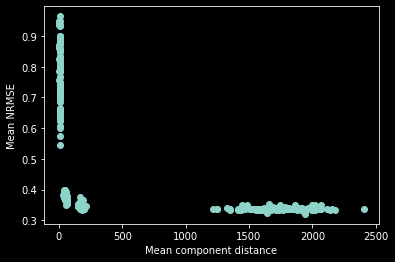

In [ ]:
plt.scatter(dist_matrix, mean_rmse)
plt.xlabel('Mean component distance')
plt.ylabel('Mean NRMSE')

In [ ]:
sum1 = []
sum2 = []
sum3 = []
sum4 = []
for i in range(400):
    if dist_matrix[i] < 50:
        sum1.append(mean_rmse[i])
    if (dist_matrix[i] >= 50) & (dist_matrix[i] < 200):
        sum2.append(mean_rmse[i])
    if (dist_matrix[i] >= 200) & (dist_matrix[i] < 500):
        sum3.append(mean_rmse[i])
    if (dist_matrix[i] >= 500):
        sum4.append(mean_rmse[i])
    


In [ ]:
final_sum = []
final_sum.append(sum1)
final_sum.append(sum2)
final_sum.append(sum3)
final_sum.append(sum4)

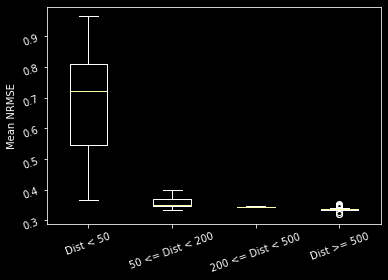

In [ ]:
plt.boxplot(final_sum)
plt.xticks([(i+1) for i in range (4) ], ['Dist < 50', '50 <= Dist < 200', '200 <= Dist < 500', 'Dist >= 500'])
plt.ylabel('Mean NRMSE')
plt.tick_params(labelrotation=20)

In [ ]:
uniq_structures = []
for s in structures:
    if s not in uniq_structures:
        uniq_structures.append(s)

In [ ]:
uniq_structures_len = dict()
for s in structures:
    if str(s) not in list(uniq_structures_len.keys()):
        uniq_structures_len[str(s)] = 1
    else:
        uniq_structures_len[str(s)] += 1

In [ ]:
uniq_structures_len

{"[['C1', 'C3'], ['C2', 'C1'], ['C2', 'C3']]": 57,
 "[['C2', 'C3'], ['C2', 'C1'], ['C3', 'C1']]": 64,
 "[['C1', 'C2'], ['C3', 'C1'], ['C3', 'C2']]": 47,
 "[['C1', 'C2'], ['C1', 'C3'], ['C2', 'C3']]": 51,
 "[['C1', 'C3'], ['C3', 'C2']]": 7,
 "[['C3', 'C2'], ['C3', 'C1']]": 1,
 "[['C2', 'C3'], ['C3', 'C1']]": 1,
 "[['C2', 'C1'], ['C3', 'C1'], ['C3', 'C2']]": 9,
 "[['C1', 'C2'], ['C2', 'C3']]": 5,
 "[['C2', 'C1']]": 1,
 "[['C1', 'C2'], ['C3', 'C1']]": 2,
 "[['C1', 'C3'], ['C2', 'C1']]": 3,
 "[['C1', 'C2'], ['C3', 'C2'], ['C3', 'C1']]": 11,
 "[['C2', 'C1'], ['C3', 'C2'], ['C3', 'C1']]": 44,
 "[['C1', 'C3'], ['C2', 'C3'], ['C2', 'C1']]": 5,
 "[['C1', 'C3'], ['C1', 'C2'], ['C3', 'C2']]": 53,
 "[['C2', 'C3'], ['C2', 'C1']]": 4,
 "[['C3', 'C2']]": 1,
 "[['C1', 'C2'], ['C1', 'C3']]": 1,
 "[['C3', 'C1'], ['C3', 'C2']]": 1,
 "[['C2', 'C1'], ['C2', 'C3']]": 1,
 "[['C2', 'C1'], ['C2', 'C3'], ['C3', 'C1']]": 14,
 "[['C1', 'C2'], ['C1', 'C3'], ['C3', 'C2']]": 9,
 "[['C1', 'C3'], ['C1', 'C2'], ['C2', 

In [ ]:
index_structure = []
for ind, struct in enumerate(structures):
    if str(struct) == "[['C2', 'C3'], ['C2', 'C1'], ['C3', 'C1']]":
        index_structure.append(ind)

## Вычисление точности через попадание в дов. инттервал реального значения

In [ ]:
hit_value = []
for i in range(400):
    m = means[i]
    c = covs[i]
    model = GMM(n_components=3, priors=w, means=m, covariances=c)
    sample = model.sample(5000)
    sample = pd.DataFrame(data=sample, columns=['C1', 'C2', 'C3'])
    modelc1 = GMM(n_components=3).from_samples(sample[['C1']].values)
    modelc2 = GMM(n_components=3).from_samples(sample[['C2']].values)
    modelc3 = GMM(n_components=3).from_samples(sample[['C3']].values)
    hitc1 = []
    hitc2 = []
    hitc3 = []
    real = real_iter[i]
    pred = pred_iter[i]

    sample1 = pd.DataFrame(data = real[0], columns=['C1'])
    c1 = []
    c11 = []
    for j in modelc1.to_responsibilities(sample1.values):
        c1.append(j.argmax())
    for j in modelc1.to_responsibilities(sample[['C1']].values):
        c11.append(j.argmax())
    sample['c1_cat'] = c11

    sample2 = pd.DataFrame(data = real[1], columns=['C2'])
    c2 = []
    c22 = []
    for j in modelc2.to_responsibilities(sample2.values):
        c2.append(j.argmax())
    for j in modelc2.to_responsibilities(sample[['C2']].values):
        c22.append(j.argmax())
    sample['c2_cat'] = c22

    sample3 = pd.DataFrame(data = real[2], columns=['C3'])
    c3 = []
    c33 = []
    for j in modelc3.to_responsibilities(sample3.values):
        c3.append(j.argmax())
    for j in modelc3.to_responsibilities(sample[['C3']].values):
        c33.append(j.argmax())
       
    sample['c3_cat'] = c33

    for j, el in enumerate(pred[0]):
        if c1[j] == 0:
            std = np.std(sample.loc[sample['c1_cat'] == 0]['C1'].values)
            if (el < real[0][j] + std) & (el > real[0][j] - std):
                hitc1.append(1)
            else:
                hitc1.append(0)
        if c1[j] == 1:
            std = np.std(sample.loc[sample['c1_cat'] == 1]['C1'].values)
            if (el < real[0][j] + std) & (el > real[0][j] - std):
                hitc1.append(1)
            else:
                hitc1.append(0)
        if c1[j] == 2:
            std = np.std(sample.loc[sample['c1_cat'] == 2]['C1'].values)
            if (el < real[0][j] + std) & (el > real[0][j] - std):
                hitc1.append(1)
            else:
                hitc1.append(0)

    for j, el in enumerate(pred[1]):
        if c2[j] == 0:
            std = np.std(sample.loc[sample['c2_cat'] == 0]['C2'].values)
            if (el < real[1][j] + std) & (el > real[1][j] - std):
                hitc2.append(1)
            else:
                hitc2.append(0)
        if c2[j] == 1:
            std = np.std(sample.loc[sample['c2_cat'] == 1]['C2'].values)
            if (el < real[1][j] + std) & (el > real[1][j] - std):
                hitc2.append(1)
            else:
                hitc2.append(0)
        if c2[j] == 2:
            std = np.std(sample.loc[sample['c2_cat'] == 2]['C2'].values)
            if (el < real[1][j] + std) & (el > real[1][j] - std):
                hitc2.append(1)
            else:
                hitc2.append(0)

    for j, el in enumerate(pred[2]):
        if c3[j] == 0:
            std = np.std(sample.loc[sample['c3_cat'] == 0]['C3'].values)
            if (el < real[2][j] + std) & (el > real[2][j] - std):
                hitc3.append(1)
            else:
                hitc3.append(0)
        if c3[j] == 1:
            std = np.std(sample.loc[sample['c3_cat'] == 1]['C3'].values)
            if (el < real[2][j] + std) & (el > real[2][j] - std):
                hitc3.append(1)
            else:
                hitc3.append(0)
        if c3[j] == 2:
            std = np.std(sample.loc[sample['c3_cat'] == 2]['C3'].values)
            if (el < real[2][j] + std) & (el > real[2][j] - std):
                hitc3.append(1)
            else:
                hitc3.append(0)
    c1_percent = np.sum(hitc1) / len(real[0])
    c2_percent = np.sum(hitc2) / len(real[1])
    c3_percent = np.sum(hitc3) / len(real[2])
    hit_value.append((c1_percent + c2_percent + c3_percent) / 3)



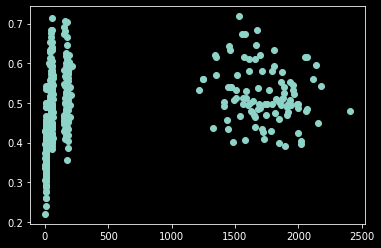

In [ ]:
plt.scatter(dist_matrix, hit_value)

In [ ]:
sum1 = []
sum2 = []
sum3 = []
sum4 = []
sum5 = []
sum6 = []
sum7 = []
for i in range(400):
    if dist_matrix[i] < 10:
        sum1.append(hit_value[i])
    if (dist_matrix[i] >= 10) & (dist_matrix[i] < 50):
        sum2.append(hit_value[i])
    if (dist_matrix[i] >= 50) & (dist_matrix[i] < 100):
        sum3.append(hit_value[i])
    if (dist_matrix[i] >= 100) & (dist_matrix[i] < 200):
        sum4.append(hit_value[i])
    if (dist_matrix[i] >= 200) & (dist_matrix[i] < 500):
        sum5.append(hit_value[i])
    if (dist_matrix[i] >= 500) & (dist_matrix[i] < 1000):
        sum6.append(hit_value[i])
    if (dist_matrix[i] >= 1000):
        sum7.append(hit_value[i])
final_sum = []
final_sum.append(sum1)
final_sum.append(sum2)
final_sum.append(sum3)
final_sum.append(sum4)
final_sum.append(sum5)
final_sum.append(sum6)
final_sum.append(sum7)

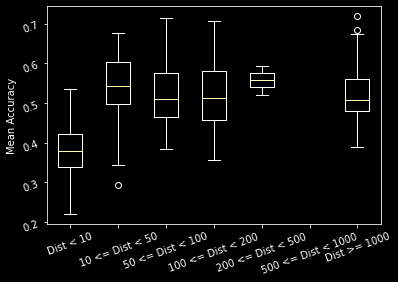

In [ ]:
plt.boxplot(final_sum)
plt.xticks([(i+1) for i in range (7) ], ['Dist < 10', '10 <= Dist < 50', '50 <= Dist < 100', '100 <= Dist < 200', '200 <= Dist < 500', '500 <= Dist < 1000', 'Dist >= 1000'])
plt.ylabel('Mean Accuracy')
plt.tick_params(labelrotation=20)

In [ ]:
node_types = {'C1':'cont', 'C2':'cont', 'C3':'cont'}
columns_for_disc = ['C1', 'C2', 'C3']
rmse_simple = []
real_simple = []
pred_simple = []
for i in range(400):
    print(i)
    train = samples_train[i]
    test = samples_test[i]
    discrete_data, coder = discretization(train, 'equal_frequency', columns_for_disc)
    bn_full = structure_learning(discrete_data, 'HC', node_types, 'K2')
    params = parameter_learning(train, node_types, bn_full, 'simple')
    save_structure(bn_full, 'all_net')
    skel = read_structure('all_net')
    save_params(params, 'all_net_param')
    params = read_params('all_net_param')
    all_bn = HyBayesianNetwork(skel, params)
    acc, rmse, real, pred, index = parall_accuracy(all_bn, test, columns_for_disc, 'simple', cpu_count)
    real_simple.append(real)
    pred_simple.append(pred)
    rmse_simple.append(rmse)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
mean_rmse_simple = []
for i in range(400):
    r1 = rmse_simple[i]['C1'] /  np.std(real_simple[i][0])
    r2 = rmse_simple[i]['C2'] / np.std(real_simple[i][1])
    r3 = rmse_simple[i]['C3'] / np.std(real_simple[i][2])
    mean_rmse_simple.append((r1 + r2 + r3) / 3)

Text(0, 0.5, 'Mean NRMSE')

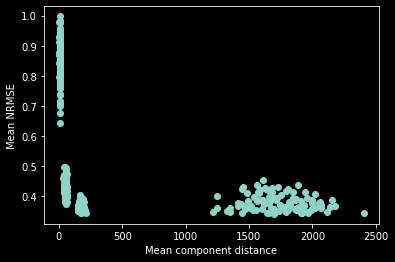

In [ ]:
plt.scatter(dist_matrix, mean_rmse_simple)
plt.xlabel('Mean component distance')
plt.ylabel('Mean NRMSE')

In [ ]:
sum1 = []
sum2 = []
sum3 = []
sum4 = []
for i in range(400):
    if dist_matrix[i] < 50:
        sum1.append(mean_rmse_simple[i])
    if (dist_matrix[i] >= 50) & (dist_matrix[i] < 200):
        sum2.append(mean_rmse_simple[i])
    if (dist_matrix[i] >= 200) & (dist_matrix[i] < 500):
        sum3.append(mean_rmse_simple[i])
    if (dist_matrix[i] >= 500):
        sum4.append(mean_rmse_simple[i])
final_sum = []
final_sum.append(sum1)
final_sum.append(sum2)
final_sum.append(sum3)
final_sum.append(sum4)

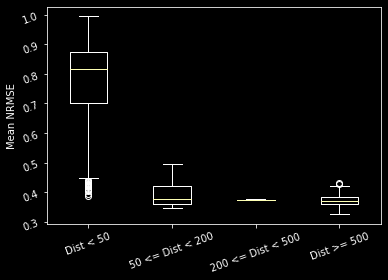

In [ ]:
plt.boxplot(final_sum)
plt.xticks([(i+1) for i in range (4) ], ['Dist < 50', '50 <= Dist < 200', '200 <= Dist < 500', 'Dist >= 500'])
plt.ylabel('Mean NRMSE')
plt.tick_params(labelrotation=20)

In [ ]:
hit_value_simple = []
for i in range(400):
    m = means[i]
    c = covs[i]
    model = GMM(n_components=3, priors=w, means=m, covariances=c)
    sample = model.sample(5000)
    sample = pd.DataFrame(data=sample, columns=['C1', 'C2', 'C3'])
    modelc1 = GMM(n_components=3).from_samples(sample[['C1']].values)
    modelc2 = GMM(n_components=3).from_samples(sample[['C2']].values)
    modelc3 = GMM(n_components=3).from_samples(sample[['C3']].values)
    hitc1 = []
    hitc2 = []
    hitc3 = []
    real = real_simple[i]
    pred = pred_simple[i]

    sample1 = pd.DataFrame(data = real[0], columns=['C1'])
    c1 = []
    c11 = []
    for j in modelc1.to_responsibilities(sample1.values):
        c1.append(j.argmax())
    for j in modelc1.to_responsibilities(sample[['C1']].values):
        c11.append(j.argmax())
    sample['c1_cat'] = c11

    sample2 = pd.DataFrame(data = real[1], columns=['C2'])
    c2 = []
    c22 = []
    for j in modelc2.to_responsibilities(sample2.values):
        c2.append(j.argmax())
    for j in modelc2.to_responsibilities(sample[['C2']].values):
        c22.append(j.argmax())
    sample['c2_cat'] = c22

    sample3 = pd.DataFrame(data = real[2], columns=['C3'])
    c3 = []
    c33 = []
    for j in modelc3.to_responsibilities(sample3.values):
        c3.append(j.argmax())
    for j in modelc3.to_responsibilities(sample[['C3']].values):
        c33.append(j.argmax())
       
    sample['c3_cat'] = c33

    for j, el in enumerate(pred[0]):
        if c1[j] == 0:
            std = np.std(sample.loc[sample['c1_cat'] == 0]['C1'].values)
            if (el < real[0][j] + std) & (el > real[0][j] - std):
                hitc1.append(1)
            else:
                hitc1.append(0)
        if c1[j] == 1:
            std = np.std(sample.loc[sample['c1_cat'] == 1]['C1'].values)
            if (el < real[0][j] + std) & (el > real[0][j] - std):
                hitc1.append(1)
            else:
                hitc1.append(0)
        if c1[j] == 2:
            std = np.std(sample.loc[sample['c1_cat'] == 2]['C1'].values)
            if (el < real[0][j] + std) & (el > real[0][j] - std):
                hitc1.append(1)
            else:
                hitc1.append(0)

    for j, el in enumerate(pred[1]):
        if c2[j] == 0:
            std = np.std(sample.loc[sample['c2_cat'] == 0]['C2'].values)
            if (el < real[1][j] + std) & (el > real[1][j] - std):
                hitc2.append(1)
            else:
                hitc2.append(0)
        if c2[j] == 1:
            std = np.std(sample.loc[sample['c2_cat'] == 1]['C2'].values)
            if (el < real[1][j] + std) & (el > real[1][j] - std):
                hitc2.append(1)
            else:
                hitc2.append(0)
        if c2[j] == 2:
            std = np.std(sample.loc[sample['c2_cat'] == 2]['C2'].values)
            if (el < real[1][j] + std) & (el > real[1][j] - std):
                hitc2.append(1)
            else:
                hitc2.append(0)

    for j, el in enumerate(pred[2]):
        if c3[j] == 0:
            std = np.std(sample.loc[sample['c3_cat'] == 0]['C3'].values)
            if (el < real[2][j] + std) & (el > real[2][j] - std):
                hitc3.append(1)
            else:
                hitc3.append(0)
        if c3[j] == 1:
            std = np.std(sample.loc[sample['c3_cat'] == 1]['C3'].values)
            if (el < real[2][j] + std) & (el > real[2][j] - std):
                hitc3.append(1)
            else:
                hitc3.append(0)
        if c3[j] == 2:
            std = np.std(sample.loc[sample['c3_cat'] == 2]['C3'].values)
            if (el < real[2][j] + std) & (el > real[2][j] - std):
                hitc3.append(1)
            else:
                hitc3.append(0)
    c1_percent = np.sum(hitc1) / len(real[0])
    c2_percent = np.sum(hitc2) / len(real[1])
    c3_percent = np.sum(hitc3) / len(real[2])
    hit_value_simple.append((c1_percent + c2_percent + c3_percent) / 3)

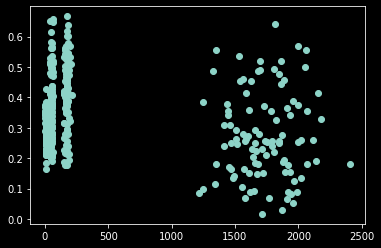

In [ ]:
plt.scatter(dist_matrix, hit_value_simple)

In [ ]:
sum1 = []
sum2 = []
sum3 = []
sum4 = []
sum5 = []
sum6 = []
sum7 = []
for i in range(400):
    if dist_matrix[i] < 10:
        sum1.append(hit_value_simple[i])
    if (dist_matrix[i] >= 10) & (dist_matrix[i] < 50):
        sum2.append(hit_value_simple[i])
    if (dist_matrix[i] >= 50) & (dist_matrix[i] < 100):
        sum3.append(hit_value_simple[i])
    if (dist_matrix[i] >= 100) & (dist_matrix[i] < 200):
        sum4.append(hit_value_simple[i])
    if (dist_matrix[i] >= 200) & (dist_matrix[i] < 500):
        sum5.append(hit_value_simple[i])
    if (dist_matrix[i] >= 500) & (dist_matrix[i] < 1000):
        sum6.append(hit_value_simple[i])
    if (dist_matrix[i] >= 1000):
        sum7.append(hit_value_simple[i])
final_sum = []
final_sum.append(sum1)
final_sum.append(sum2)
final_sum.append(sum3)
final_sum.append(sum4)
final_sum.append(sum5)
final_sum.append(sum6)
final_sum.append(sum7)

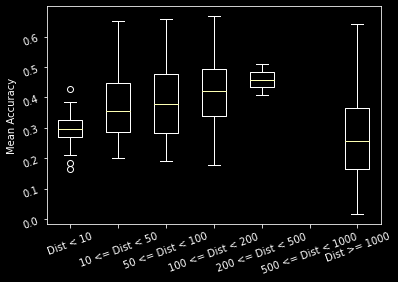

In [ ]:
plt.boxplot(final_sum)
plt.xticks([(i+1) for i in range (7) ], ['Dist < 10', '10 <= Dist < 50', '50 <= Dist < 100', '100 <= Dist < 200', '200 <= Dist < 500', '500 <= Dist < 1000', 'Dist >= 1000'])
plt.ylabel('Mean Accuracy')
plt.tick_params(labelrotation=20)